In [28]:
import numpy as np
import pandas as pd
import cv2
from numpy import random, moveaxis
import os
import pyautogui
from win32api import GetSystemMetrics
import matplotlib.pyplot as plt

In [109]:
source = 'fer2013/sample_fer2013.csv'
sample = pd.read_csv(source)
print(sample.shape)
sample.head(20)

(13, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


9076
2304


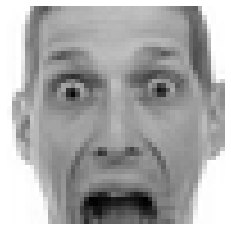

In [71]:
line = sample['pixels'][9]
print(len(line))
image_data = np.asarray([int(x) for x in line.split()])  # numpy array
print(len(image_data))
img = image_data.reshape((48,48)).astype('uint8')  # 2-d numpy array
# img = cv2.bitwise_not(img)  # w&b bitwise inverted or do not multiply by 255
    
# print(f'ID:{id} \n{clases[clase]}')
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()

**New detections**

In [3]:
# face detector
protoPath = os.path.join('models', 'deploy.prototxt')
modelPath = os.path.join('models', 'res10_300x300_ssd_iter_140000.caffemodel')
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
threshold = 0.45  # to filter out week face detections
px_filter = 15  # size filter to ensure a sufficiently large face
divider = 100  # every 100 fps (iterations) we save and c comes back to zero and then to start the counting again

In [143]:
VID = os.path.join('media', 'recording.avi')
webcam = cv2.VideoCapture(VID)
vectors = []  # pixels
emos = []  # emotion
Usage = []  # Usage

c = 1
while True:
    ret, frame = webcam.read()
    fps = webcam.get(cv2.CAP_PROP_POS_FRAMES)  # CAP_PROP_FS
    
    if ret is False:
        print('Ok. Finished')
        break
    
    if c%divider==0:  # c comes back to zero and then to start the counting again from 1
        frame = cv2.normalize(frame, None, 10, 245, cv2.NORM_MINMAX)
        (h_frame, w_frame) = frame.shape[:2]

        imageBlob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 187.0, 123.), swapRB=False, crop=False)
        detector.setInput(imageBlob)
        detections = detector.forward()

        for i in range(0, detections.shape[2]):

            confidence = detections[0, 0, i, 2]

            if confidence > threshold:
                box = detections[0, 0, i, 3:7] * np.array([w_frame, h_frame, w_frame, h_frame])
                (startX, startY, endX, endY) = box.astype("int")  # x, y coordinates of the bounding box for the face
                (startX, startY, endX, endY) = (5+startX, 5+startY, 5+endX, 5+endY)  # offset for classification

                face = frame[startY:endY, startX:endX]
                face = cv2.resize(face, (300, 300), interpolation=cv2.INTER_AREA)
                (fH, fW) = face.shape[:2]
                # n1 = os.path.join('fer2013', 'us', str(i)+'_'+str(fps)+'_color.jpg')
                # cv2.imwrite(n1, face)

                if fW < px_filter or fH < px_filter:
                    continue

                gray = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
                # cv2.imwrite('text2.jpg', gray)

                gray48 = cv2.resize(gray, (48, 48), interpolation=cv2.INTER_AREA)
                
                flat = np.array(gray48).flatten('C')  # vectorizing the image
                flat_str = ' '.join([str(elem) for elem in flat])  # convert the array vector to a string
                vectors.append(flat_str)
                emos.append('0')  # temporary emotion
                Usage.append('Training')  # all for training
                
                n2 = os.path.join('fer2013', 'us', str(i)+'_'+str(int(fps))+'_48.jpg')
                cv2.imwrite(n2, gray48)
    c+=1
            
webcam.release()
cv2.destroyAllWindows()

Ok. Finished


In [144]:
print(f'elements: {len(vectors)}')

elements: 360


In [145]:
print(len(vectors[0]))
# print(vectors[0])

6911


In [146]:
addon = {
    'emotion': emos,
    'pixels': vectors,
    'Usage': Usage,
}
addon_data = pd.DataFrame.from_dict(addon)
print(addon_data.shape)
addon_data.head()

(360, 3)


,emotion,pixels,Usage
0,0,10 10 10 10 10 10 10 10 10 10 11 11 11 13 15 1...,Training
1,0,20 15 19 24 26 27 30 33 36 42 36 33 36 44 52 6...,Training
2,0,32 31 31 30 31 32 32 32 34 38 43 44 46 54 67 6...,Training
3,0,108 147 152 153 147 131 117 115 115 114 115 11...,Training
4,0,43 34 32 34 34 33 34 37 42 53 69 93 114 122 13...,Training


7988
2304


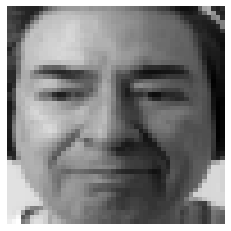

In [148]:
lin = addon_data['pixels'][84]
print(len(lin))
img_dt = np.asarray([int(x) for x in lin.split()])  # numpy array
print(len(img_dt))
im = img_dt.reshape((48,48)).astype('uint8')  # 2-d numpy array
# img = cv2.bitwise_not(img)  # w&b bitwise inverted or do not multiply by 255
    
# print(f'ID:{id} \n{clases[clase]}')
plt.imshow(im, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()